# Model Training for Dataset A

### Importing libraries

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import gensim.downloader as gensim_api
import numpy as np
import json

# Load word embeddings
word2vec = gensim_api.load("word2vec-google-news-300")
glove = gensim_api.load("glove-wiki-gigaword-300")
fasttext = gensim_api.load("fasttext-wiki-news-subwords-300")

### Loading Dataset (Json)

In [20]:
with open('../data/ATE_Train.json','r') as f:
    train_json = json.load(f)
with open('../data/ATE_Val.json','r') as f:
    val_json = json.load(f)
with open('../data/ATE_Test.json','r') as f:
    test_json = json.load(f)

In [66]:
def get_embeddings(text, embeddings):
    words = text.split()
    embeddings_list = [embeddings[word] if word in embeddings else np.zeros(embeddings.vector_size) for word in words]
    return torch.tensor(embeddings_list, dtype=torch.float32)

# Convert JSON dataset to numerical format
def get_dataset(word_embedding, json_file, label_mapping):
    numerical_dataset = []
    for key, example in json_file.items():
        text_embeddings = get_embeddings(example["text"], word_embedding)
        label_sequence = torch.tensor([label_mapping[label] for label in example["labels"]], dtype=torch.float32)
        numerical_dataset.append((text_embeddings, label_sequence))
    return numerical_dataset

In [67]:
label_mapping = {"B": 0, "I": 1, "O": 2}
word2vec_train_embeddings = get_dataset(word_embedding=word2vec, json_file=train_json, label_mapping=label_mapping)
word2vec_val_embeddings = get_dataset(word_embedding=word2vec, json_file=val_json, label_mapping=label_mapping)
word2vec_test_embeddings = get_dataset(word_embedding=word2vec, json_file=test_json, label_mapping=label_mapping)

glove_train_embeddings = get_dataset(word_embedding=glove, json_file=train_json, label_mapping=label_mapping)
glove_val_embeddings = get_dataset(word_embedding=glove, json_file=val_json, label_mapping=label_mapping)
glove_test_embeddings = get_dataset(word_embedding=glove, json_file=test_json, label_mapping=label_mapping)

fasttext_train_embeddings = get_dataset(word_embedding=fasttext, json_file=train_json, label_mapping=label_mapping)
fasttext_val_embeddings = get_dataset(word_embedding=fasttext, json_file=val_json, label_mapping=label_mapping)
fasttext_test_embeddings = get_dataset(word_embedding=fasttext, json_file=test_json, label_mapping=label_mapping)

### Models (RNN, LSTM, GRU)

In [68]:
class VanillaRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(VanillaRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size, hidden_size, self.n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        c0 = torch.zeros(self.n_layers, x.size(0), self.hidden_size).to(x.device)  # Initialize cell state
        out, (hn, cn) = self.lstm(x, (h0, c0))  # Forward propagate LSTM
        out = self.fc(out)
        return out

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)  # Initialize hidden state
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out


### Train and loss functions

In [72]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import warnings

def train_model(model, train_data, val_data, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_f1_scores = []
    val_f1_scores = []

    for epoch in range(num_epochs):
        model.train()
        for inputs, labels in train_data:
            # print(inputs.shape)
            optimizer.zero_grad()
            inputs = inputs.unsqueeze(0)
            
            outputs = model(inputs)
            # print(outputs.shape)
            # print(labels.dtype)
            # print(type(outputs), type(inputs), type(labels))
            
            outputs = outputs.to(torch.float)
            labels = torch.tensor(labels, dtype=torch.long)
            # print(outputs.shape, labels.shape)
            loss = criterion(outputs.view(-1, output_size), labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_loss = 0.0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in val_data:
                # Add a batch dimension to the inputs
                inputs = inputs.unsqueeze(0)
                outputs = model(inputs)
                labels = torch.tensor(labels, dtype=torch.long)
                val_loss += criterion(outputs.view(-1, output_size), labels)
                _, predicted = torch.max(outputs, 2)
                predictions.extend(predicted.view(-1).cpu().numpy())
                true_labels.extend(labels.view(-1).cpu().numpy())

        val_loss /= len(val_data)
        train_losses.append(loss.item())
        val_losses.append(val_loss)

        # Calculate F1 scores
        train_f1 = f1_score(true_labels, predictions, average='macro')
        val_f1 = f1_score(true_labels, predictions, average='macro')
        train_f1_scores.append(train_f1)
        val_f1_scores.append(val_f1)

        print(f'Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}, Validation F1 Score: {val_f1:.4f}, Train Loss: {loss.item():.4f}, Train F1 Score: {train_f1:.4f}.....')

    # Function to plot loss
    def plot_loss(train_losses, val_losses):
        plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.show()

    # Function to plot F1 score
    def plot_f1_score(train_f1_scores, val_f1_scores):
        plt.plot(range(1, len(train_f1_scores) + 1), train_f1_scores, label='Training F1 Score')
        plt.plot(range(1, len(val_f1_scores) + 1), val_f1_scores, label='Validation F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('Training and Validation F1 Score')
        plt.legend()
        plt.show()
    plot_loss(train_losses, val_losses)
    plot_f1_score(train_f1_scores, val_f1_scores)


### Testing 

In [73]:
def calculate_f1_score(model, test_loader):
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.unsqueeze(0)
            outputs = model(inputs)
            labels = torch.tensor(labels, dtype=torch.long)
            _, predicted = torch.max(outputs, 2)
            predictions.extend(predicted.view(-1).cpu().numpy())
            true_labels.extend(labels.view(-1).cpu().numpy())
    test_f1 = f1_score(true_labels, predictions, average='macro')
    return test_f1

In [74]:
import warnings
warnings.filterwarnings('ignore')

### Model Training and Evaluation using Word2Vec Embeddings ###


Training lstm model with word2vec embeddings:


Epoch 1/10, Validation Loss: 0.1691, Validation F1 Score: 0.7659, Train Loss: 0.0884, Train F1 Score: 0.7659.....
Epoch 2/10, Validation Loss: 0.1333, Validation F1 Score: 0.8134, Train Loss: 0.0890, Train F1 Score: 0.8134.....
Epoch 3/10, Validation Loss: 0.1072, Validation F1 Score: 0.8434, Train Loss: 0.0953, Train F1 Score: 0.8434.....
Epoch 4/10, Validation Loss: 0.0901, Validation F1 Score: 0.8667, Train Loss: 0.0759, Train F1 Score: 0.8667.....
Epoch 5/10, Validation Loss: 0.0779, Validation F1 Score: 0.8881, Train Loss: 0.0542, Train F1 Score: 0.8881.....
Epoch 6/10, Validation Loss: 0.0706, Validation F1 Score: 0.8981, Train Loss: 0.0260, Train F1 Score: 0.8981.....
Epoch 7/10, Validation Loss: 0.0575, Validation F1 Score: 0.9204, Train Loss: 0.0082, Train F1 Score: 0.9204.....
Epoch 8/10, Validation Loss: 0.0397, Validation F1 Score: 0.9468, Train Loss: 0.0195, Train F1 Score: 0.9468.....
Epoch 9/10, Validation Loss: 0.0309, Validation F1 Score: 0.9608, Train Loss: 0.0185, Tr

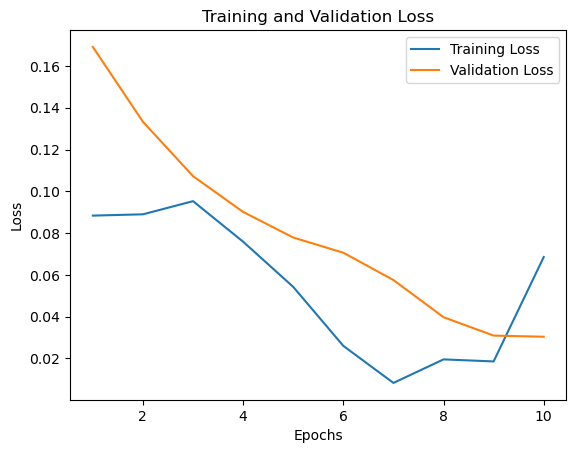

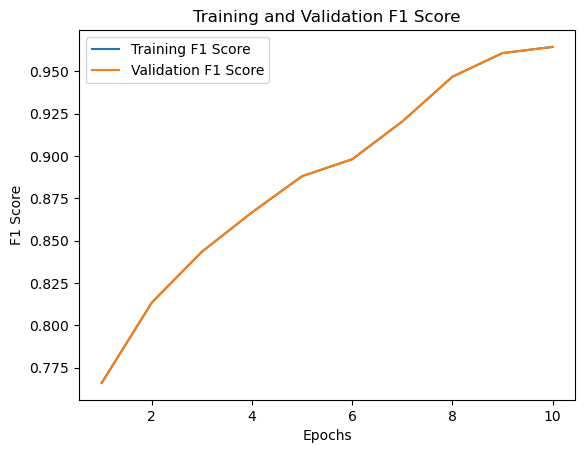

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.9644

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1577, Validation F1 Score: 0.7785, Train Loss: 0.0674, Train F1 Score: 0.7785.....
Epoch 2/10, Validation Loss: 0.1267, Validation F1 Score: 0.8206, Train Loss: 0.0522, Train F1 Score: 0.8206.....
Epoch 3/10, Validation Loss: 0.1059, Validation F1 Score: 0.8500, Train Loss: 0.0462, Train F1 Score: 0.8500.....
Epoch 4/10, Validation Loss: 0.0852, Validation F1 Score: 0.8838, Train Loss: 0.0399, Train F1 Score: 0.8838.....
Epoch 5/10, Validation Loss: 0.0697, Validation F1 Score: 0.9032, Train Loss: 0.0342, Train F1 Score: 0.9032.....
Epoch 6/10, Validation Loss: 0.0571, Validation F1 Score: 0.9232, Train Loss: 0.0332, Train F1 Score: 0.9232.....
Epoch 7/10, Validation Loss: 0.0404, Validation F1 Score: 0.9450, Train Loss: 0.0219, Train F1 Score: 0.9450.....
Epoch 8/10, Validation Loss: 0.0294, Validation F1 Score: 0.9606, Train Loss: 0.0128, T

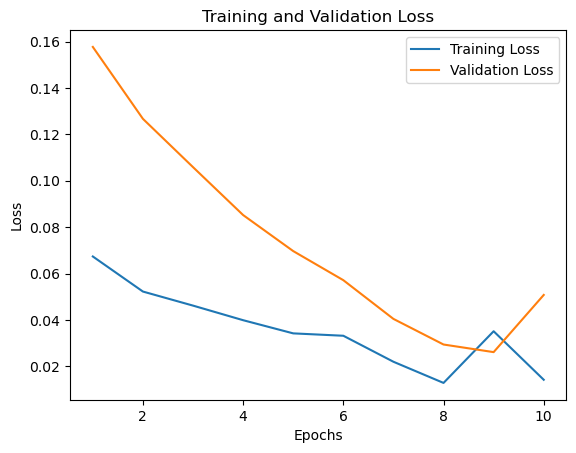

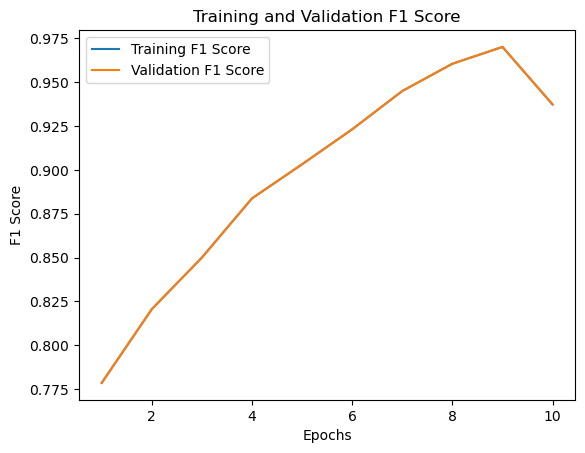

gru Model Testing using word2vec embeddings (Test F1 Score): 0.9373

Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1844, Validation F1 Score: 0.7642, Train Loss: 0.1071, Train F1 Score: 0.7642.....
Epoch 2/10, Validation Loss: 0.1522, Validation F1 Score: 0.7864, Train Loss: 0.0883, Train F1 Score: 0.7864.....
Epoch 3/10, Validation Loss: 0.1396, Validation F1 Score: 0.8047, Train Loss: 0.0935, Train F1 Score: 0.8047.....
Epoch 4/10, Validation Loss: 0.1361, Validation F1 Score: 0.8131, Train Loss: 0.0753, Train F1 Score: 0.8131.....
Epoch 5/10, Validation Loss: 0.1404, Validation F1 Score: 0.8083, Train Loss: 0.0979, Train F1 Score: 0.8083.....
Epoch 6/10, Validation Loss: 0.1299, Validation F1 Score: 0.8184, Train Loss: 0.0667, Train F1 Score: 0.8184.....
Epoch 7/10, Validation Loss: 0.1440, Validation F1 Score: 0.8026, Train Loss: 0.0963, Train F1 Score: 0.8026.....
Epoch 8/10, Validation Loss: 0.1299, Validation F1 Score: 0.8313, Train Loss: 0.

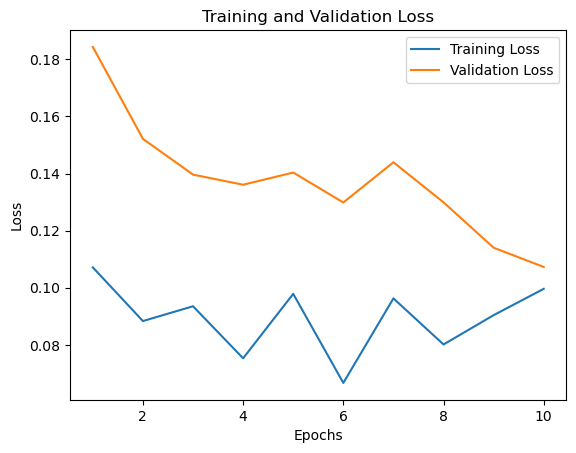

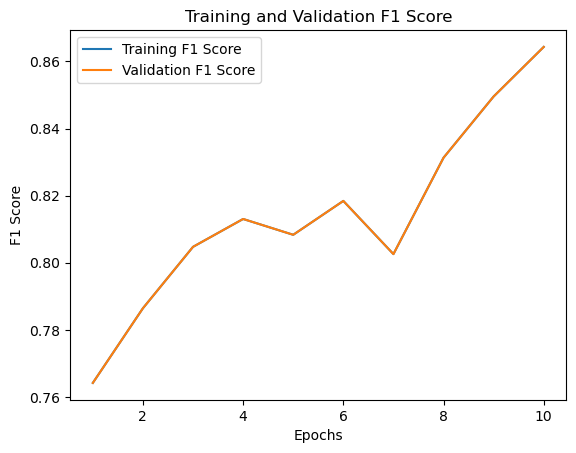

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.8643


In [75]:
models = {
    'lstm': LSTMModel,
    'gru': GRUModel,
    'vanilla_rnn': VanillaRNN
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, word2vec_train_embeddings, word2vec_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, word2vec_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')

### Model Training and Evaluation using Glove Embeddings ###


Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.2078, Validation F1 Score: 0.7385, Train Loss: 0.2031, Train F1 Score: 0.7385.....
Epoch 2/10, Validation Loss: 0.1841, Validation F1 Score: 0.7599, Train Loss: 0.1483, Train F1 Score: 0.7599.....
Epoch 3/10, Validation Loss: 0.1684, Validation F1 Score: 0.7802, Train Loss: 0.1140, Train F1 Score: 0.7802.....
Epoch 4/10, Validation Loss: 0.1526, Validation F1 Score: 0.8005, Train Loss: 0.1034, Train F1 Score: 0.8005.....
Epoch 5/10, Validation Loss: 0.1377, Validation F1 Score: 0.8207, Train Loss: 0.0886, Train F1 Score: 0.8207.....
Epoch 6/10, Validation Loss: 0.1256, Validation F1 Score: 0.8353, Train Loss: 0.0709, Train F1 Score: 0.8353.....
Epoch 7/10, Validation Loss: 0.1142, Validation F1 Score: 0.8607, Train Loss: 0.0759, Train F1 Score: 0.8607.....
Epoch 8/10, Validation Loss: 0.1105, Validation F1 Score: 0.8571, Train Loss: 0.0801, Train F1 Score: 0.8571.....
Epoch 9/10, Validation Loss: 0.102

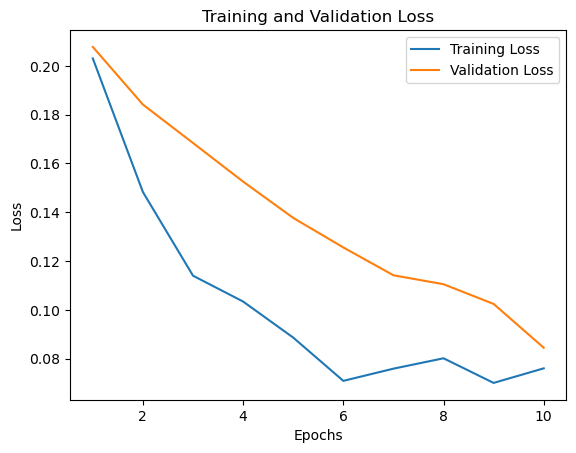

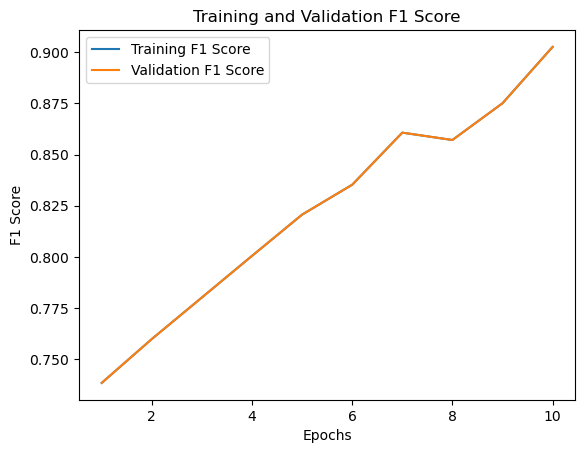

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.9026

Training lstm model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1982, Validation F1 Score: 0.7371, Train Loss: 0.1337, Train F1 Score: 0.7371.....
Epoch 2/10, Validation Loss: 0.1523, Validation F1 Score: 0.7960, Train Loss: 0.1320, Train F1 Score: 0.7960.....
Epoch 3/10, Validation Loss: 0.1212, Validation F1 Score: 0.8482, Train Loss: 0.0967, Train F1 Score: 0.8482.....
Epoch 4/10, Validation Loss: 0.1007, Validation F1 Score: 0.8776, Train Loss: 0.0698, Train F1 Score: 0.8776.....
Epoch 5/10, Validation Loss: 0.0800, Validation F1 Score: 0.9127, Train Loss: 0.0551, Train F1 Score: 0.9127.....
Epoch 6/10, Validation Loss: 0.0676, Validation F1 Score: 0.9323, Train Loss: 0.0273, Train F1 Score: 0.9323.....
Epoch 7/10, Validation Loss: 0.0618, Validation F1 Score: 0.9410, Train Loss: 0.0423, Train F1 Score: 0.9410.....
Epoch 8/10, Validation Loss: 0.0591, Validation F1 Score: 0.9439, Train Loss: 0

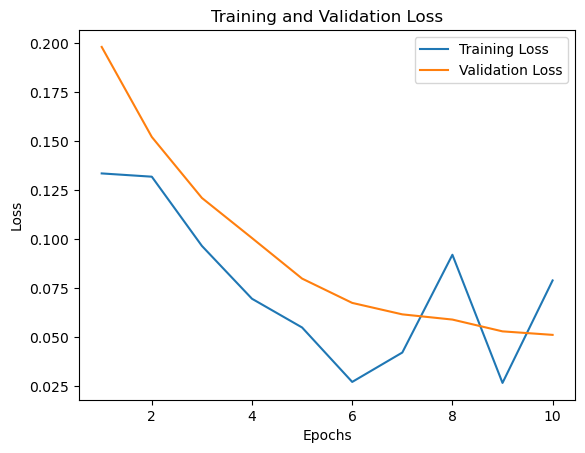

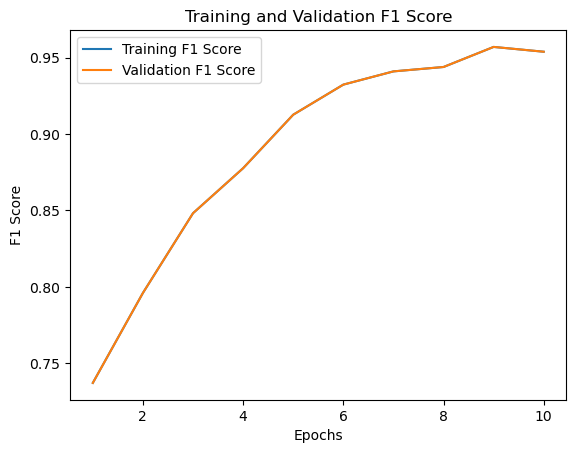

lstm Model Testing using word2vec embeddings (Test F1 Score): 0.9539

Training gru model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1953, Validation F1 Score: 0.7414, Train Loss: 0.1243, Train F1 Score: 0.7414.....
Epoch 2/10, Validation Loss: 0.1490, Validation F1 Score: 0.8043, Train Loss: 0.1043, Train F1 Score: 0.8043.....
Epoch 3/10, Validation Loss: 0.1204, Validation F1 Score: 0.8527, Train Loss: 0.0837, Train F1 Score: 0.8527.....
Epoch 4/10, Validation Loss: 0.0998, Validation F1 Score: 0.8823, Train Loss: 0.0775, Train F1 Score: 0.8823.....
Epoch 5/10, Validation Loss: 0.0810, Validation F1 Score: 0.9117, Train Loss: 0.0652, Train F1 Score: 0.9117.....
Epoch 6/10, Validation Loss: 0.0647, Validation F1 Score: 0.9362, Train Loss: 0.0472, Train F1 Score: 0.9362.....
Epoch 7/10, Validation Loss: 0.0543, Validation F1 Score: 0.9534, Train Loss: 0.0727, Train F1 Score: 0.9534.....
Epoch 8/10, Validation Loss: 0.0536, Validation F1 Score: 0.9551, Train Loss: 0.0234, T

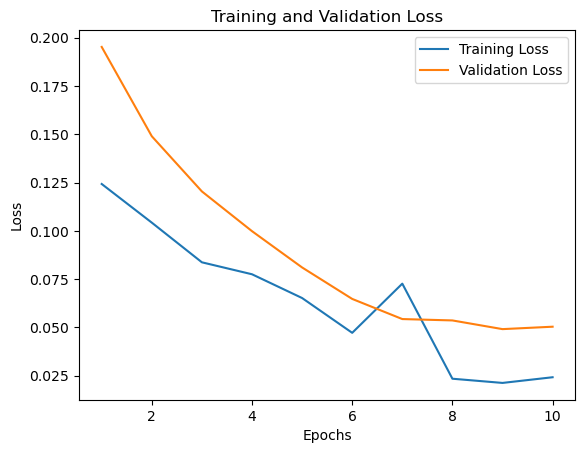

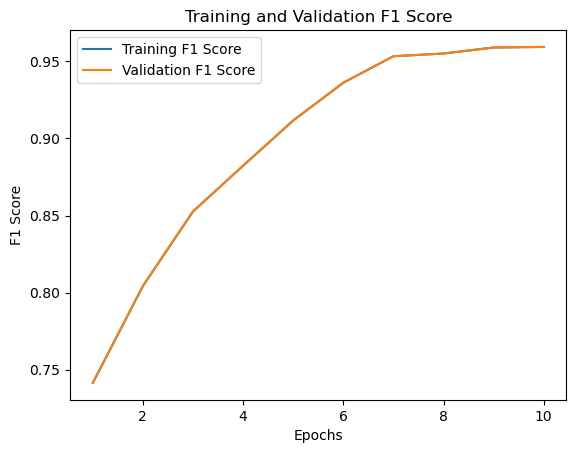

gru Model Testing using word2vec embeddings (Test F1 Score): 0.9594


In [76]:
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, glove_train_embeddings, glove_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, glove_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')

### Model Training and Evaluation using fasttesxt Embeddings ###


Training vanilla_rnn model with word2vec embeddings:
Epoch 1/10, Validation Loss: 0.1764, Validation F1 Score: 0.7582, Train Loss: 0.1145, Train F1 Score: 0.7582.....
Epoch 2/10, Validation Loss: 0.1557, Validation F1 Score: 0.7962, Train Loss: 0.1040, Train F1 Score: 0.7962.....
Epoch 3/10, Validation Loss: 0.1447, Validation F1 Score: 0.8079, Train Loss: 0.1008, Train F1 Score: 0.8079.....
Epoch 4/10, Validation Loss: 0.1377, Validation F1 Score: 0.8110, Train Loss: 0.1027, Train F1 Score: 0.8110.....
Epoch 5/10, Validation Loss: 0.1295, Validation F1 Score: 0.8227, Train Loss: 0.1081, Train F1 Score: 0.8227.....
Epoch 6/10, Validation Loss: 0.1265, Validation F1 Score: 0.8265, Train Loss: 0.1203, Train F1 Score: 0.8265.....
Epoch 7/10, Validation Loss: 0.1277, Validation F1 Score: 0.8232, Train Loss: 0.1481, Train F1 Score: 0.8232.....
Epoch 8/10, Validation Loss: 0.1320, Validation F1 Score: 0.8132, Train Loss: 0.1786, Train F1 Score: 0.8132.....
Epoch 9/10, Validation Loss: 0.129

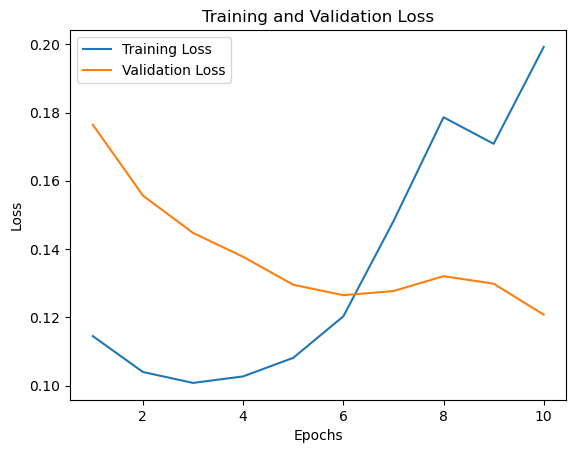

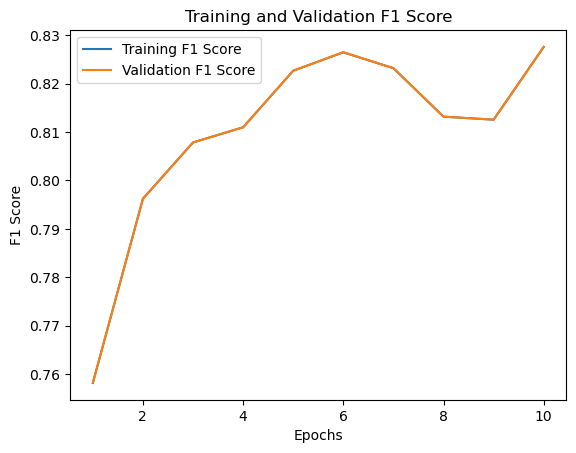

vanilla_rnn Model Testing using word2vec embeddings (Test F1 Score): 0.8276

Training lstm model with word2vec embeddings:


In [77]:
import torch.nn as nn
import torch.optim as optim

# Models
models = {
    'vanilla_rnn': VanillaRNN,
    'lstm': LSTMModel,
    'gru': GRUModel
}

# Hyperparameters
input_size = 300
hidden_size = 128
output_size = 3  # Number of classes (BIO tags)
learning_rate = 0.001
num_epochs = 10

for model_name, model_class in models.items():
    print(f'\nTraining {model_name} model with word2vec embeddings:')
    model = model_class(input_size, hidden_size, output_size)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    train_model(model, fasttext_train_embeddings, fasttext_val_embeddings, criterion, optimizer, num_epochs)
    
    # Calculate and print the test F1 score
    test_f1_score = calculate_f1_score(model, fasttext_test_embeddings)
    print(f'{model_name} Model Testing using word2vec embeddings (Test F1 Score): {test_f1_score:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), f'{model_name}_word2vec_model.pth')


----------------------------------------------------------------------------- EOF --------------------------------------------------------------------------------